# Countryrisk

In [404]:
import wbdata
import pandas as pd
import pandas_profiling
import datetime
import quandl
%config IPCompleter.greedy=True
import pandas_datareader
import urllib3


# 1- Extracting and Cleaning the Data from IMF, WB and BIS

## Country selection


In [405]:
### fecthing country names from IMF database to get all ISO codes
countrycodes = pd.read_csv('coucodes.csv', delimiter = ';', encoding = "ISO-8859-1")
countrycodes = countrycodes[["IMF Name", "ISO Code", "ISO2 Code"]]
countrycodes.reset_index(level=0, inplace=True)
countrycodes = countrycodes.rename(columns={'IMF Name': 'country'})

countries = ["Brazil",  "Mexico", "India",  "Russia", "Switzerland", "Uruguay",
             "Korea", "Thailand", "Ecuador", "Bolivia", "Costa Rica", "Colombia", "Paraguay",
             "Chile", "South Africa", "Taiwan", "Turkey", "Ukraine", "Nigeria", "Indonesia",
             "Bangladesh", "Philippines", "Pakistan", "Egypt", "Ethiopia", "Vietnam", "Tanzania",
             "Myanmar", "Algeria", "Sudan", "Uganda", "Morocco", "Saudi Arabia", "Uzbekistan", "Malaysia",
             "Afghanistan", "Ghana"]

#Argentina, Venezuela e Iraq are not working - Monthly
#
countrycodes = countrycodes[countrycodes["country"].isin(countries)]

## WB


In [407]:
#downloading data from worldbank

from pandas_datareader import wb

worldbank_data = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_", "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 2010, end = 2020, freq = "M")
worldbank_data2 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_",  "IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1999, end = 2009, freq = "M")
worldbank_data3 = pandas_datareader.wb.download(indicator = ["DPANUSLCU", "TOT", "TOTRESV","UNEMPSA_","IPTOTSAKD", "DXGSRMRCHSAKD","DSTKMKTXD", "DMGSRMRCHSAKD","CPTOTSAXN"], country = countrycodes["ISO Code"], start = 1990, end = 1998, freq = "M")

worldbank_data = pd.concat([worldbank_data, worldbank_data2])
worldbank_data = pd.concat([worldbank_data, worldbank_data3])

worldbank_data.reset_index(inplace=True)

worldbank_data_conc = pd.merge(worldbank_data, countrycodes, on="country")


## IMF

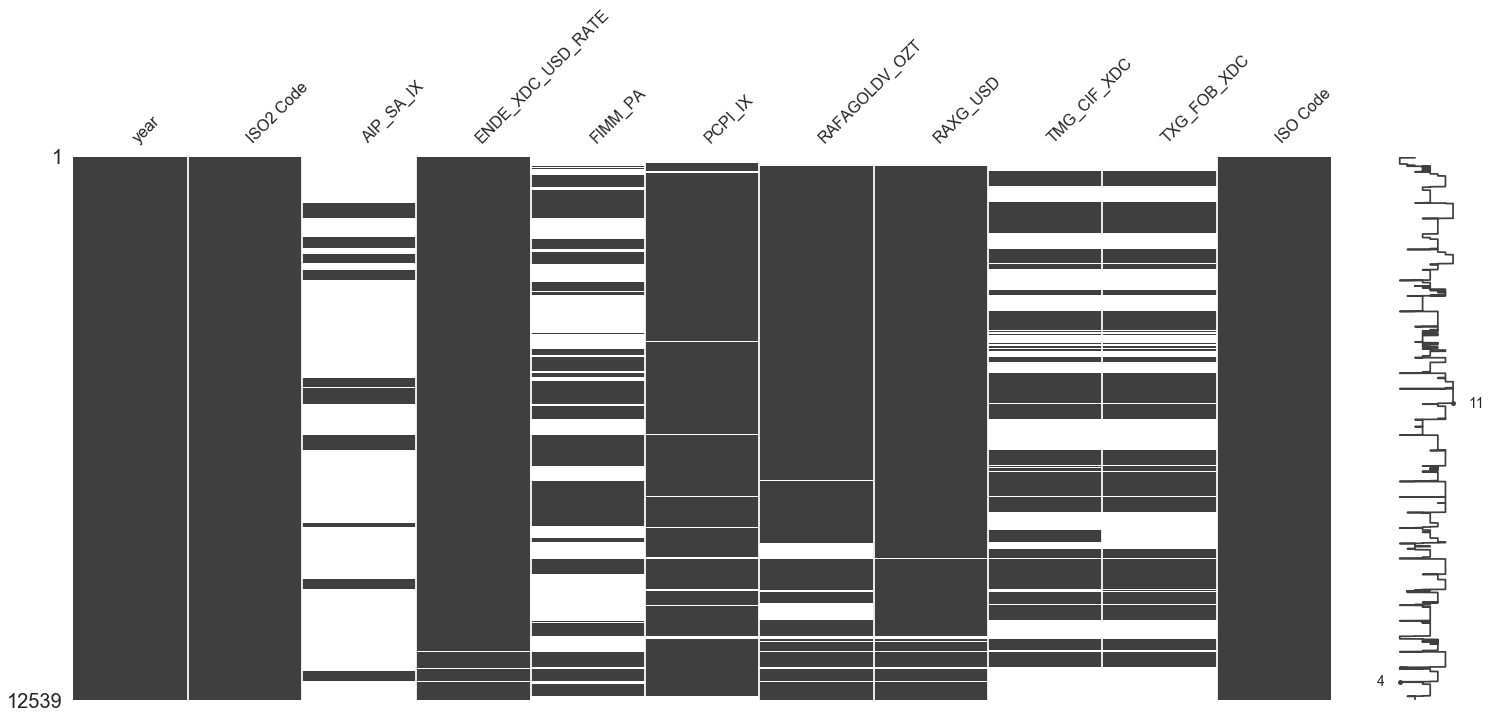

In [408]:
# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".RAFAGOLDV_OZT+RAXG_USD+TXG_FOB_XDC+TMG_CIF_XDC+FIMM_PA+PCPI_IX+ENDE_XDC_USD_RATE+AIP_SA_IX.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
stack_m = pd.merge(stack, countrycodes[["ISO2 Code", "ISO Code"]], on = "ISO2 Code")
msno.matrix(stack_m)

In [409]:
#The same for price commodities index


# Example: loading IMF data into pandas
#Monthly data
# Import libraries
import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/PCTOT/M."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')
#Variables
variables = ".x_gdp.?startPeriod=1990&endPeriod=2030"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.drop(["indicator"], axis = 1)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code", "@OBS_VALUE" : "PCTOT"})
#Next: Analyze the missing data and data range

stack_m2 = stack.drop_duplicates(["year", "ISO2 Code"])

stack_m3 = pd.merge(stack_m, stack_m2, on = ["ISO2 Code", "year"], how = "left")

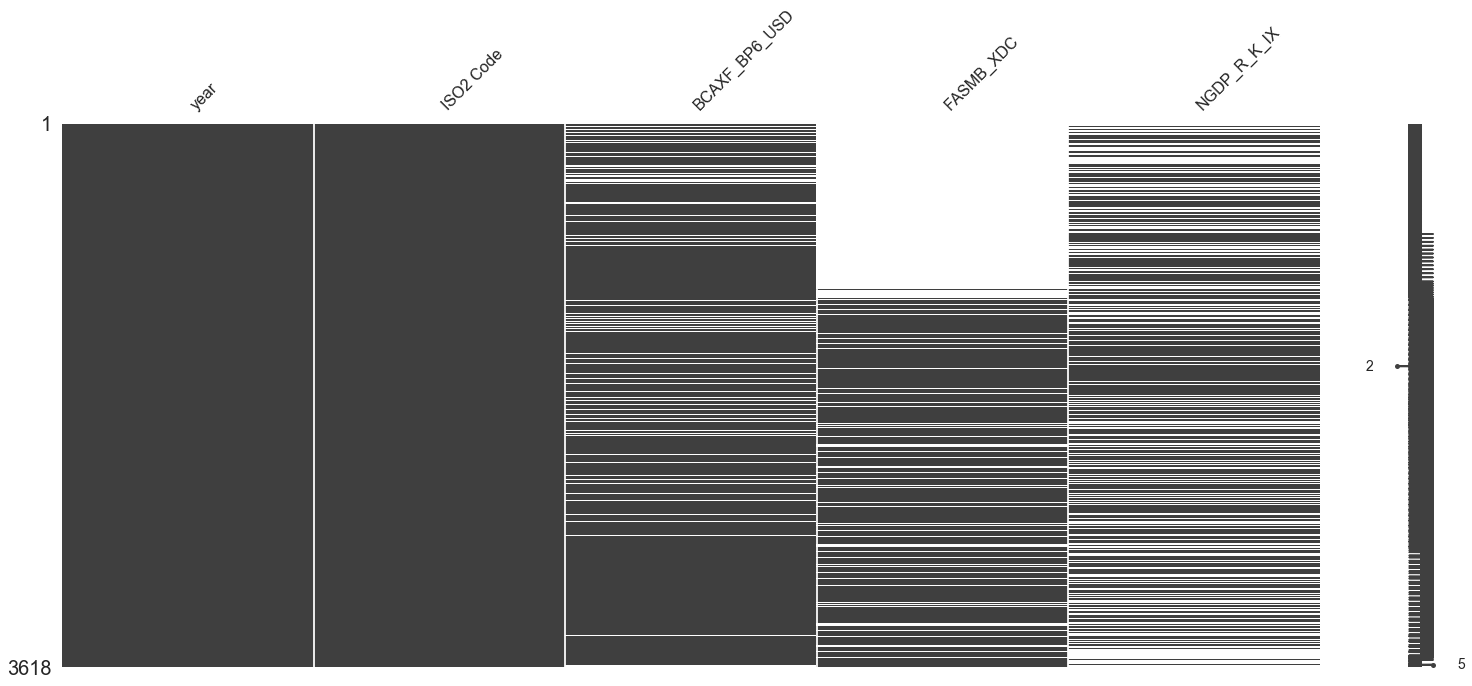

In [410]:
#Quarterly data


import requests
import pandas as pd

url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q."

#Countries
couvalues = list(countrycodes["ISO2 Code"].values)
iso2 = countrycodes["ISO2 Code"].str.cat(sep='+')
iso3 = countrycodes["ISO Code"].str.cat(sep=',')

#Variables
variables = ".NGDP_R_K_IX+PCTOT+BCAXF_BP6_USD+FASMB_XDC.?startPeriod=1990&endPeriod=2020"

url = url+iso2+variables

# Get data from the above URL using the requests package
data = requests.get(url).json()


#### stacking IMF data and creating a dataframe
stack = []
data2 = pd.DataFrame()
for x in range(len(data['CompactData']['DataSet']['Series'])-1):
    data2 = pd.DataFrame(data['CompactData']['DataSet']['Series'][x]["Obs"])[["@OBS_VALUE", "@TIME_PERIOD"]]
    data2["country"] = data['CompactData']['DataSet']['Series'][x]["@REF_AREA"]
    data2["indicator"] = data['CompactData']['DataSet']['Series'][x]["@INDICATOR"]
    stack.append(data2)
stack = pd.concat(stack)


stack = stack.set_index(["@TIME_PERIOD", 'country', 'indicator']).unstack(level=-1)
stack.columns = stack.columns.droplevel(0)

stack.reset_index(inplace=True)


stack = stack.rename(columns={'@TIME_PERIOD': 'year', "country": "ISO2 Code"})
#Next: Analyze the missing data and data range

import missingno as msno
msno.matrix(stack)
stack_q = pd.merge(stack, countrycodes[["ISO2 Code"]], on = "ISO2 Code")


In [411]:
# merging monthly and quarterly

stack_q["year"] = pd.to_datetime(stack_q["year"])
stack_m3["year"] = pd.to_datetime(stack_m3["year"])

stack = pd.merge(stack_m3, stack_q, on = ["year", "ISO2 Code"], how = "left")

## OECD

In [412]:
from cif import cif

data_all, subjects_all, measures_all = cif.createDataFrameFromOECD(countries = countrycodes["ISO Code"].tolist(), frequency = 'M', subject = ["SPASTT01"])


Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/AFG.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/DZA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BGD.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BOL.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/BRA.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all


C:\Users\vitor\Anaconda3\lib\site-packages\cif\cif.py:248: FutureWarning:

.labels was deprecated in version 0.24.0. Use .codes instead.

C:\Users\vitor\Anaconda3\lib\site-packages\cif\cif.py:249: FutureWarning:

the 'labels' keyword is deprecated, use 'codes' instead



Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/CHL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all


C:\Users\vitor\Anaconda3\lib\site-packages\cif\cif.py:251: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/COL.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/CRI.SPASTT01..M/all
Error: No available records, please change parameters
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/ECU.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/EGY.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/ETH.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/GHA.SPASTT01..M/all
Error: 400
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/IND.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/IND.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting URL http://stats.oecd.org/SDMX-JSON/data/MEI/IDN.SPASTT01..M/all
Data downloaded from https://stats.oecd.org/SDMX-JSON/data/MEI/IDN.SPASTT01..M/all?dimensionAtObservation=AllDimensions
Requesting

In [413]:
oecd = data_all.stack(level = 0)
oecd.columns = oecd.columns.droplevel(0)
oecd = oecd.reset_index()
oecd = oecd.drop(['GP', 'GY'], axis=1)  
oecd["level_0"] = pd.to_datetime(oecd["level_0"])


In [499]:
full = pd.merge(stack, oecd, left_on = ["ISO Code", "year"], right_on = ["country", "level_0"], how = "left")


## BIS

In [500]:
from io import BytesIO
import pandas as pd
from urllib.request import urlopen
from zipfile import ZipFile

z = urlopen('https://www.bis.org/statistics/full_bis_total_credit_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_TOTAL_CREDIT_DATAFLOW_csv_col.csv')
credit =pd.read_csv(myzip)


credit = credit[(credit["Borrowing sector"] == "Private non-financial sector") | (credit["Borrowing sector"] == "General government")]
credit = credit[(credit["Lending sector"] == "All sectors")]
credit = credit[(credit["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
credit = credit[(credit["Unit type"] == "Percentage of GDP")]
credit = credit[(credit["TC_ADJUST"] == "A")]
credit = credit[(credit["Valuation"] == "Market value")]
credit = (credit.set_index(['Borrowing sector', 'BORROWERS_CTY'])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack('Borrowing sector')
   .reset_index())
credit = credit.iloc[13:]

In [501]:
z = urlopen('https://www.bis.org/statistics/full_bis_dsr_csv.zip')
myzip = ZipFile(BytesIO(z.read())).extract('WEBSTATS_DSR_DATAFLOW_csv_col.csv')
debt_service =pd.read_csv(myzip)

debt_service = debt_service[(debt_service["Borrowers"] == "Private non-financial sector")]
debt_service = debt_service[(debt_service["BORROWERS_CTY"].isin(countrycodes["ISO2 Code"]))]
debt_service = (debt_service.set_index(['BORROWERS_CTY', "Borrowers"])
   .rename_axis(['Year'], axis=1)
   .stack()
   .unstack("Borrowers")
   .reset_index())

debt_service = debt_service.iloc[5:]
debt_service.columns = debt_service.columns = ["BORROWERS_CTY", "Year", "debt_service"]

In [502]:
from bs4 import BeautifulSoup, SoupStrainer
import requests

url = "https://oefdatascience.github.io/REIGN.github.io/menu/reign_current.html"

page = requests.get(url)    
data = page.text
soup = BeautifulSoup(data)

links = []
for link in soup.find_all(attrs={'href': re.compile("http")}):
    links.append(link.get('href'))


sub = "https://cdn.rawgit.com/OEFDataScience/REIGN.github.io/gh-pages/data_sets/REIGN"


link = [word for word in links if word.startswith(sub)]

import pandas as pd
couprisk = pd.read_csv(link[0])
couprisk = couprisk[["country", "year", "month", "couprisk"]]
couprisk["month"] = couprisk["month"].astype(int)
couprisk["month"] = couprisk.month.map("{:02}".format)
couprisk["year"] = couprisk["year"].round().astype(int).astype(str) + "-" + couprisk["month"].astype(str)+"-" + "01"



In [503]:
couprisk = couprisk[couprisk["country"].isin(countries)]
couprisk = pd.merge(couprisk, countrycodes, on = "country")
couprisk = couprisk.drop(["index", "ISO Code"], 1)
couprisk = couprisk.drop_duplicates(["year", "country"])

In [504]:
credit["Year"] = pd.to_datetime(credit["Year"], errors = "coerce")
debt_service["Year"] = pd.to_datetime(debt_service["Year"], errors = "coerce")
couprisk["year"] = pd.to_datetime(couprisk["year"], errors = "coerce")


full = pd.merge(full, credit, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, debt_service, left_on = ["ISO2 Code", "year"], right_on = ["BORROWERS_CTY", "Year"], how = "left")
full = pd.merge(full, couprisk, on = ["ISO2 Code", "year"], how = "left")


In [505]:
full

,year,ISO2 Code,AIP_SA_IX,ENDE_XDC_USD_RATE,FIMM_PA,PCPI_IX,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC,...,BORROWERS_CTY_x,Year_x,General government,Private non-financial sector,BORROWERS_CTY_y,Year_y,debt_service,country_y,month,couprisk
0,1990-01-01,AF,NaN,42.82278,NaN,NaN,0.965,254.882926641746,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,01,0.006598
1,1990-02-01,AF,NaN,42.82278,NaN,NaN,0.965,253.055987279599,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,02,0.007205
2,1990-03-01,AF,NaN,42.82278,NaN,NaN,0.965,237.475415615162,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,03,0.006140
3,1990-04-01,AF,NaN,42.82278,NaN,NaN,0.965,248.63301639814,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,04,0.008673
4,1990-05-01,AF,NaN,42.82278,NaN,NaN,0.965,255.341546858395,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Afghanistan,05,0.008243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12534,2019-05-01,UZ,NaN,8485.91,NaN,NaN,11.65,11402.36724917,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,05,0.000623
12535,2019-06-01,UZ,NaN,8562.34,NaN,NaN,11.26,11832.1083657368,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,06,0.000681
12536,2019-07-01,UZ,NaN,8666.71,NaN,NaN,10.54,12648.2113086272,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,07,0.000682
12537,2019-08-01,UZ,NaN,9373.93,NaN,NaN,10.47,12479.4498302165,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaT,NaN,Uzbekistan,08,0.000679


# 2 - Creating variables and cleaning the Data

In [506]:
#droping duplicated columns
full = full.drop(columns = ["country_x", "Year_x","country_y", "Year_y", "BORROWERS_CTY_x", "BORROWERS_CTY_y", "Year_y","level_0"])


In [507]:
#to numeric
cols = full.columns.drop(["ISO2 Code", "year"])

full[cols] = full[cols].apply(pd.to_numeric, errors='coerce')

In [508]:
#creating variable

iso = full["ISO2 Code"]

full = full.groupby('ISO2 Code').ffill()

full["ISO2 Code"] = iso

full["gdp_growth"] = full.groupby('ISO2 Code', sort=False).NGDP_R_K_IX.apply(
     lambda x: x.pct_change(12))

full.rename(columns={'Private non-financial sector':'credit_private', 'General government': 'credit_government'}, inplace=True)

full["credit_growth"] = full.groupby('ISO2 Code', sort=False).credit_private.apply(
     lambda x: x.pct_change(12))

full["inflation"] = full.groupby('ISO2 Code', sort=False).PCPI_IX.apply(
     lambda x: x.pct_change(12))

full["stock_growth"]  = full.groupby('ISO2 Code', sort=False).IXOB.apply(
     lambda x: x.pct_change(1))


full["exchange_change"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(1))

full["exchange_12a"] = full.groupby('ISO2 Code', sort=False).ENDE_XDC_USD_RATE.apply(
     lambda x: x.pct_change(12))

full["industrial_growth"] = full.groupby('ISO2 Code', sort=False).AIP_SA_IX.apply(
     lambda x: x.pct_change(1))

full["commodities_growth"] = full.groupby('ISO2 Code', sort=False).PCTOT.apply(
     lambda x: x.pct_change(12))

full["reserves_gdp"] = full["RAXG_USD"]/full["NGDP_R_K_IX"]

full["imports_gdp"] = full["TMG_CIF_XDC"]/full["NGDP_R_K_IX"]

full["exports_gdp"] = full["TXG_FOB_XDC"]/full["NGDP_R_K_IX"]


In [509]:
#Counting missing values by country
full2 = full
g = full2.groupby('ISO2 Code')
g.count().rsub(g.size(), axis=0)

,year,AIP_SA_IX,ENDE_XDC_USD_RATE,FIMM_PA,PCPI_IX,RAFAGOLDV_OZT,RAXG_USD,TMG_CIF_XDC,TXG_FOB_XDC,ISO Code,...,credit_growth,inflation,stock_growth,exchange_change,exchange_12a,industrial_growth,commodities_growth,reserves_gdp,imports_gdp,exports_gdp
ISO2 Code,,,,,,,,,,,,,,,,,,,,,
AF,0,356,0,203,170,0,0,356,356,356,...,356,182,356,1,12,356,12,356,356,356
BD,0,357,0,89,42,0,0,0,0,357,...,357,54,357,1,12,357,12,357,357,357
BO,0,357,0,60,0,0,0,357,357,357,...,357,12,357,1,12,357,12,0,357,357
BR,0,12,0,0,0,0,0,0,0,357,...,84,12,1,1,12,13,12,72,72,72
CH,0,357,0,357,0,0,0,0,0,357,...,12,12,1,1,12,357,12,0,0,0
CL,0,84,0,119,0,0,0,357,357,357,...,12,12,1,1,12,85,12,0,357,357
CO,0,120,0,62,0,0,0,0,0,357,...,93,12,13,1,12,121,12,48,48,48
CR,0,120,0,357,0,0,0,0,0,357,...,357,12,357,1,12,121,12,12,12,12
DZ,0,357,0,50,0,0,0,204,204,357,...,357,12,357,1,12,357,12,357,357,357


In [510]:
#Dropping columns used to create the new variables
#Scaling

full3 = full2.drop(["ISO Code", "FASMB_XDC", "credit_government", "RAFAGOLDV_OZT",  "TXG_FOB_XDC", "TMG_CIF_XDC", "RAXG_USD", "PCTOT", "AIP_SA_IX", "ENDE_XDC_USD_RATE", "PCPI_IX", "IXOB"], 1 )
full3 = full3.groupby('ISO2 Code').transform(lambda x: (x - x.mean()) / x.std())
full3["ISO2 Code"] = full2["ISO2 Code"]
full3["year"] = full2["year"]
full3["year2"] = full3["year"].dt.strftime('%Y%m%d').astype(float)
full3 = pd.get_dummies(full3, columns=['ISO2 Code'], prefix = ['Country'])
full3 = full3.set_index("year")


In [511]:
#Scaling
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#scaler.fit(full3)
#full4 = pd.DataFrame(scaler.transform(full3), columns=full3.columns, index = full3.index)


In [512]:
#Imputing missing data with KNN

from fancyimpute import IterativeImputer, IterativeSVD, MatrixFactorization,NuclearNormMinimization, BiScaler, KNN, SoftImpute

X_filled_knn = KNN().fit_transform(full3)


Imputing row 1/12539 with 16 missing, elapsed time: 74.507
Imputing row 101/12539 with 13 missing, elapsed time: 75.328
Imputing row 201/12539 with 12 missing, elapsed time: 75.682
Imputing row 301/12539 with 10 missing, elapsed time: 75.931
Imputing row 401/12539 with 12 missing, elapsed time: 76.200
Imputing row 501/12539 with 10 missing, elapsed time: 76.522
Imputing row 601/12539 with 10 missing, elapsed time: 76.739
Imputing row 701/12539 with 10 missing, elapsed time: 76.917
Imputing row 801/12539 with 7 missing, elapsed time: 77.023
Imputing row 901/12539 with 7 missing, elapsed time: 77.104
Imputing row 1001/12539 with 7 missing, elapsed time: 77.178
Imputing row 1101/12539 with 8 missing, elapsed time: 77.258
Imputing row 1201/12539 with 0 missing, elapsed time: 77.298
Imputing row 1301/12539 with 0 missing, elapsed time: 77.298
Imputing row 1401/12539 with 0 missing, elapsed time: 77.298
Imputing row 1501/12539 with 4 missing, elapsed time: 77.334
Imputing row 1601/12539 with

In [513]:
full_fill = pd.DataFrame(data=X_filled_knn, columns=full3.columns, index = full3.index)
full2 = full2.set_index("year")
full_fill["ISO2 Code"] = full2["ISO2 Code"]
full_fill["exchange_change"] = full2["exchange_change"]
full_fill["exchange_12a"] = full2["exchange_12a"]

In [514]:
import statsmodels.api as sm

### Creating FX gap variable

groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['exchange_change']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['fx_gap'] = trend
    bs = bs.append(g)

full_fill = bs

In [515]:
### Creating credit gap variable
groups = full_fill.groupby('ISO2 Code')

group_keys = list(groups.groups.keys())


bs2 = pd.DataFrame()

for key in group_keys:

    g = groups.get_group(key).copy()
    target = g['credit_private']

    cycle, trend = sm.tsa.filters.hpfilter(target, lamb=400000)

    g['credit_gap'] = trend
    bs2 = bs2.append(g)

full_fill = bs2

# Definition of dependent variable

In [516]:
import numpy as np

full_fill["dummy"] = np.where(full_fill['exchange_change'] >0.1, 1, 0) #10 percent variation

#full_fill["threshold"] = full_fill.groupby("ISO2 Code")["exchange_change"].transform("mean") + 2*(full_fill.groupby("ISO2 Code")["exchange_change"].transform("std"))
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > full_fill["threshold"], 1, 0) # > 2 stdev threshold


crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise["exchange_change"].shift(-1)
crise.fillna(0, inplace=True)


In [517]:
bs2['indicator'] = bs2["lag_1"] + bs2["lag_2"] + bs2["lag_3"] + bs2["lag_4"] + bs2["lag_5"] + bs2["lag_6"] + bs2["lag_7"] + bs2["lag_8"] + bs2["lag_9"] + bs2["lag_10"] + bs2["lag_11"] +bs2["lag_12"]
bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)


bs2['indicator'] = bs2["lag_1"] +bs2["lag_2"]  + bs2["lag_3"] #+ bs2["lag_4"] + bs2["lag_5"] +bs2["lag_6"]
#bs2['indicator2'] = np.where(bs2['indicator'] > 0, 1, 0)

In [518]:
full_fill = bs2

In [519]:
### Preparing machine learning pipeline 

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier

In [520]:
columns = full_fill.columns
columns = columns.drop(["NGDP_R_K_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "indicator2", "fx_gap", "exchange_change", "month"])

# K- Fold


In [32]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)
X = X.drop(["ISO2 Code"], axis =1)

In [33]:
X

,FIMM_PA,BCAXF_BP6_USD,debt_service,gdp_growth,credit_growth,inflation,stock_growth,industrial_growth,commodities_growth,reserves_gdp,...,Country_SD,Country_TH,Country_TR,Country_TZ,Country_UA,Country_UG,Country_UY,Country_UZ,Country_VN,Country_ZA
year,,,,,,,,,,,,,,,,,,,,,
1990-01-01,0.000430,0.373460,0.712857,0.222701,0.455031,0.004709,0.001383,0.454027,0.388878,-0.004361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02-01,0.000422,0.372554,0.662446,0.243039,0.457866,0.004761,-0.000417,0.454057,0.387355,0.006298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03-01,0.000422,0.372555,0.661373,0.243470,0.457940,0.004761,-0.000479,0.454057,0.387359,0.006694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04-01,0.000422,0.372556,0.663864,0.242393,0.457713,0.004760,-0.000309,0.454051,0.387360,0.005908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-05-01,0.000422,0.372556,0.664965,0.241899,0.457606,0.004760,-0.000229,0.454047,0.387362,0.005580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-01,0.000051,0.339117,0.156757,0.264866,0.423975,0.001792,0.009289,0.448641,0.401636,0.059403,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-09-01,0.000051,0.339117,0.156757,0.264866,0.423975,0.001821,0.008610,0.448630,0.400794,0.063027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-10-01,0.000051,0.365111,0.154054,0.264866,0.423133,0.001799,0.009149,0.448629,0.393773,0.062421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [34]:
### train test split

X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0,
                                                   stratify=full_fill2['indicator2'])

In [35]:
# Spot-Check Algorithms
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('LDA'  , LinearDiscriminantAnalysis()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('SVM'  , SVC(probability=True)))
    basedModels.append(('AB'   , AdaBoostClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XGB'   , XGBClassifier()))


    
    return basedModels

In [36]:
from sklearn.metrics import confusion_matrix


def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state= 1990)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [37]:
from plotly import graph_objs as go
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [38]:
from plotly import graph_objs as go

In [39]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.800289 (0.016652)
LDA: 0.805189 (0.016911)
KNN: 0.967321 (0.007830)
CART: 0.891699 (0.023686)
NB: 0.756152 (0.019364)
SVM: 0.776696 (0.022540)
AB: 0.870910 (0.012340)
GBM: 0.925162 (0.013140)
RF: 0.987428 (0.004054)
ET: 0.987722 (0.005211)
XGB: 0.914112 (0.013845)


In [40]:
model =  ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)



array([[2566,   24],
       [  62,  295]], dtype=int64)

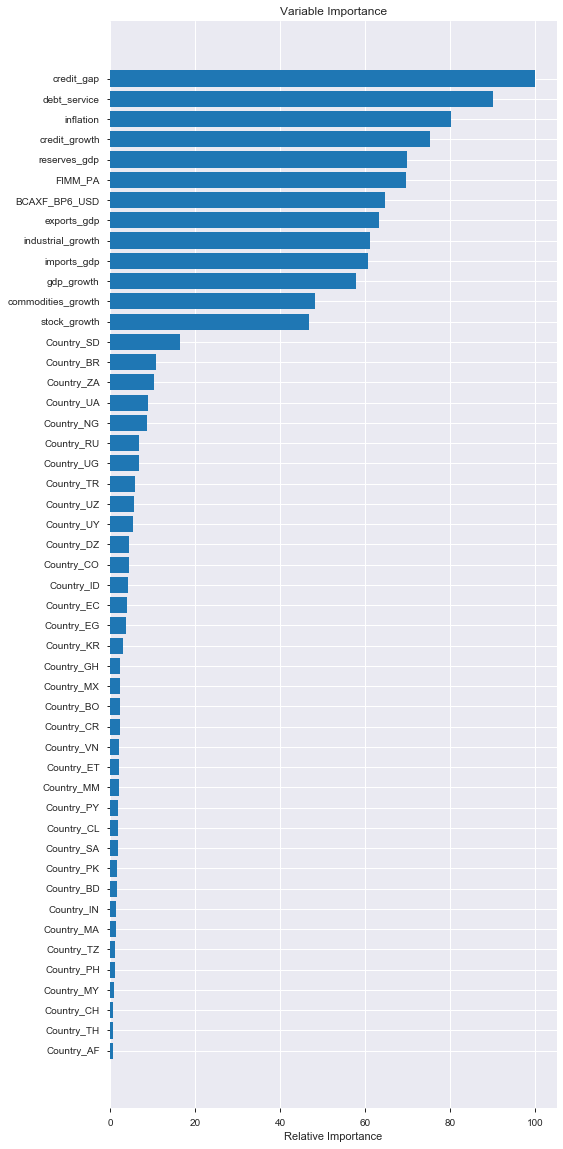

<Figure size 7200x10800 with 0 Axes>

In [41]:
### feature importance

clf = ExtraTreesClassifier(random_state= 1984)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.figure(figsize=(100,150))
plt.show()

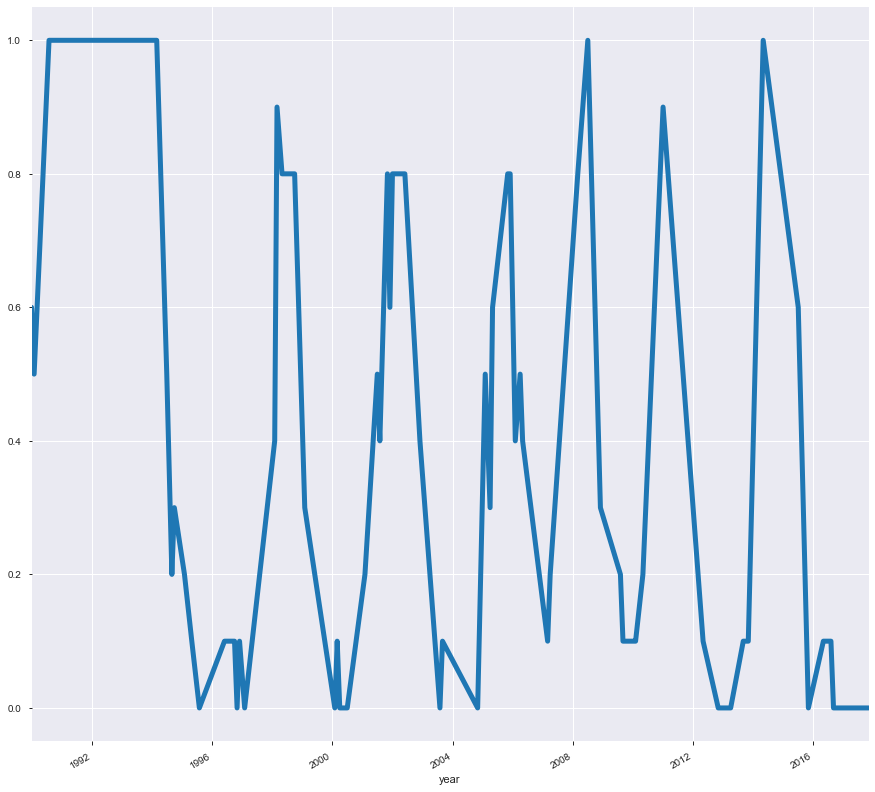

In [42]:
X_test["pred"] = y_prob
X_test2 = X_test[X_test["Country_BR"] > 0]
X_test2['pred'].plot(linewidth=5, figsize=(15,15))


# Time-Test

In [118]:
full_fill2 = full_fill.loc["1990-01-01":"2017-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2]
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)

X = X.drop(["ISO2 Code"], axis =1)

X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2017-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2017-12-31"]



In [44]:
models = GetBasedModel()
names,results = BasedLine2(X_train, Y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.209453 (0.177681)
LDA: 0.250343 (0.180683)
KNN: 0.303843 (0.131814)
CART: 0.388773 (0.127050)
NB: 0.166465 (0.107475)
SVM: 0.239153 (0.170976)
AB: 0.286141 (0.186925)
GBM: 0.331845 (0.171922)
RF: 0.326128 (0.136377)
ET: 0.263609 (0.164457)
XGB: 0.363729 (0.166182)


In [119]:

model =  XGBClassifier()
model= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
#confusion_matrix(Y_test, y_pred)

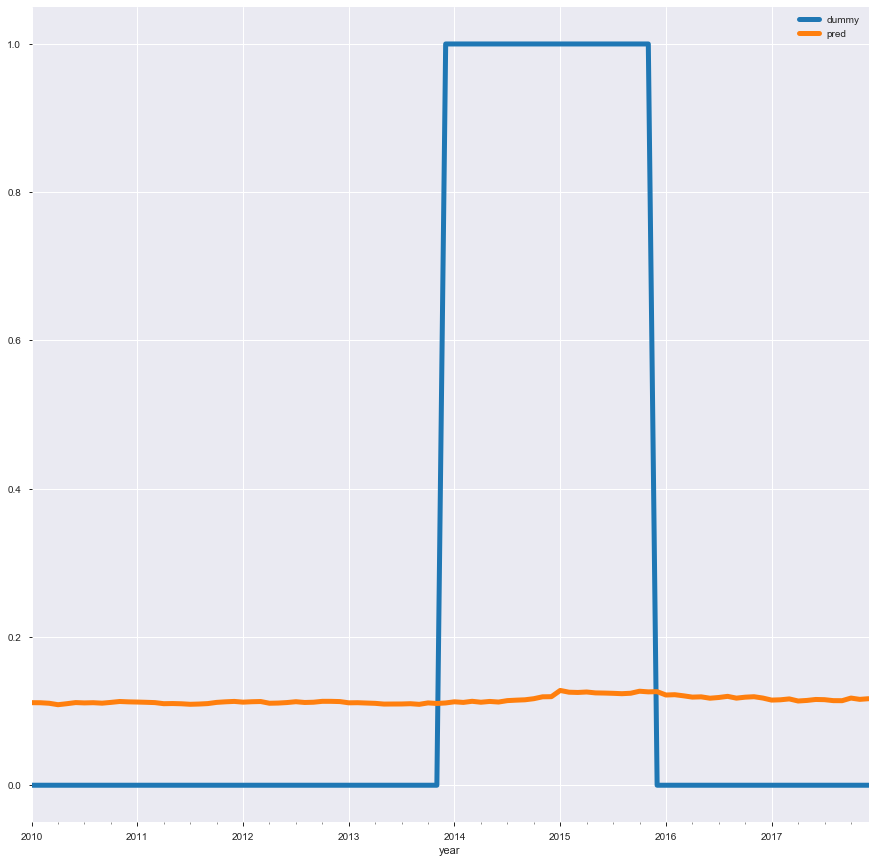

In [123]:
from matplotlib import cm

X_test["pred"] = y_prob
X_test["dummy"] = Y_test
X_test2 = X_test[X_test["Country_RU"] > 0]
X_test2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))


In [47]:
a = full[full["exchange_change"] > 0.1]
a = a[a["year"]> "2010-01-01"]
a["ISO2 Code"]

1330     BR
1371     BR
1378     BR
2447     CO
3883     EG
3891     EG
3895     EG
4172     ET
4258     ET
4587     GH
6331     MM
7085     MY
7437     NG
7452     NG
7453     NG
8202     PK
9189     SD
9204     SD
9256     SD
9265     SD
9956     TR
9975     TR
10948    UY
11678    ZA
11698    ZA
11734    ZA
11761    ZA
12050    RU
12051    RU
12058    RU
12062    RU
12373    UA
12379    UA
12382    UA
12385    UA
12455    UZ
12511    UZ
Name: ISO2 Code, dtype: object

In [48]:
X_test2["dummy"]

year
2010-01-01    0
2010-02-01    0
2010-03-01    0
2010-04-01    0
2010-05-01    0
             ..
2017-08-01    0
2017-09-01    0
2017-10-01    0
2017-11-01    0
2017-12-01    0
Name: dummy, Length: 96, dtype: int32

# Time-Test (variables in differences)

In [603]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill3 = full_fill2
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
X =  full_fill2[columns2].groupby("ISO2 Code").diff()
Y = full_fill2['indicator2']
X = pd.concat((X, full_fill3.filter(regex='Country')), axis=1)

X = X.fillna(X.mean())
X = X.fillna(0)

X_train = X.loc["1990-01-01":"2014-12-31"]
X_test = X.loc["2015-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2014-12-31"]
Y_test = Y.loc["2015-01-01":"2019-12-31"]

In [547]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

cv = TimeSeriesSplit(n_splits=10)




params = {
        'max_depth': range (2, 10),
        'n_estimators': [10,  1000],
        'learning_rate': [0.1, 0.01]
        }

clf = GridSearchCV(XGBClassifier(), params, n_jobs=-1, 
                   cv=cv, scoring= "balanced_accuracy",verbose=2, refit=True)



#model =   XGBClassifier()
#model = MLPClassifier(solver='lbfgs', alpha=0.1,hidden_layer_sizes=(52, 42), random_state=1)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
confusion_matrix(Y_test, y_pred)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 22.4min finished


array([[1807,   36],
       [ 182,   24]], dtype=int64)

In [242]:
#models = GetBasedModel()
#names,results = BasedLine2(X_train, Y_train,models)
#PlotBoxR().PlotResult(names,results)

C:\Users\vitor\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



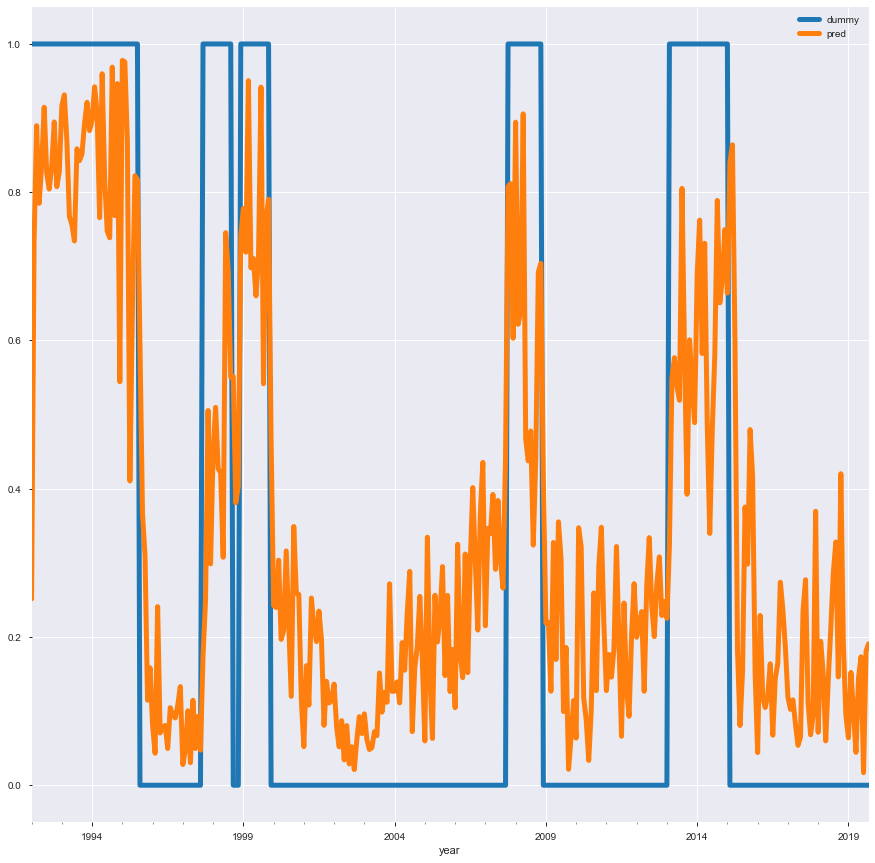

In [604]:
y_pred = clf.predict(X)
y_prob = clf.predict_proba(X)[:,1]
#confusion_matrix(Y_test, y_pred)

X["pred"] = y_prob
X["dummy"] = Y


X2 = X[X["Country_UA"] > 0]
cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
X2["hp"] = trend.diff()
X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))


In [250]:
X_test2["pred"].rolling(window=12).mean()

year
2010-01-01         NaN
2010-02-01         NaN
2010-03-01         NaN
2010-04-01         NaN
2010-05-01         NaN
                ...   
2017-08-01    0.147840
2017-09-01    0.156552
2017-10-01    0.159558
2017-11-01    0.141324
2017-12-01    0.132278
Name: pred, Length: 96, dtype: float64

In [138]:
a = full[full["ISO2 Code"] == "BR"]
a["ENDE_XDC_USD_RATE"]


1070    0.000006
1071    0.000011
1072    0.000015
1073    0.000019
1074    0.000020
          ...   
1422    3.940100
1423    3.831600
1424    3.764300
1425    4.137900
1426    4.163800
Name: ENDE_XDC_USD_RATE, Length: 357, dtype: float64

full_fill

In [525]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill2 = full_fill2.drop("exchange_12a", axis = 1)

full_fill2 = full_fill2[full_fill2["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill3.filter(regex='Country')))

X =  full_fill2[columns2]
#X = X.groupby(["ISO2 Code"])
X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator2']


X = X.fillna(X.mean())


X_train = X.loc["1990-01-01":"2009-12-31"]
X_test = X.loc["2010-01-01":"2019-12-31"]

Y_train = Y.loc["1990-01-01":"2009-12-31"]
Y_test = Y.loc["2010-01-01":"2019-12-31"]

model =   XGBClassifier()


model= MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
y_prob = model.predict_proba(X)[:,1]

confusion_matrix(Y_test, y_pred)


KeyError: "['exchange_12a'] not in index"

In [524]:
X

,FIMM_PA,BCAXF_BP6_USD,debt_service,couprisk,gdp_growth,credit_growth,inflation,stock_growth,exchange_12a,industrial_growth,commodities_growth,reserves_gdp,imports_gdp,exports_gdp,credit_gap
year,,,,,,,,,,,,,,,
1990-01-01,6.353026,0.448592,3.510142,6.467721,-1.257409,0.766379,2.165235,0.241259,0.000000,0.235226,-0.200717,-1.828522,-1.432827,-1.574036,-0.912398
1990-02-01,17.351041,0.448592,3.176361,3.818192,-1.016566,0.611209,2.046855,0.117158,0.000000,0.030344,-0.264149,-1.439769,-1.104689,-1.259677,-0.909787
1990-03-01,0.433293,0.448592,4.267542,4.921871,-1.016567,0.054079,1.743145,-0.233909,0.000000,1.005730,-0.265387,-1.278741,-1.327751,-1.440449,-0.907176
1990-04-01,-0.110096,0.986359,4.267542,2.207625,-1.016567,0.286542,1.743184,0.268037,0.000000,-0.360683,-0.265374,-1.602677,-1.616740,-1.668987,-0.904570
1990-05-01,-0.106153,0.986359,2.655122,3.613518,-1.016567,0.286546,1.743223,-0.090960,0.000000,-0.412207,-0.265360,-1.342497,-1.390037,-1.495668,-0.901970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,-0.117753,0.170266,-0.245926,-0.755538,-0.460313,0.482837,-0.318323,-0.073322,0.054518,-0.170515,-0.538332,1.326369,2.283954,2.777833,1.466696
2019-06-01,-0.117753,0.170266,-0.245926,-0.742285,-0.460313,0.482837,-0.320258,-0.055126,-0.006122,-0.064335,-0.160817,1.338917,1.609719,1.953785,1.466661
2019-07-01,-0.117753,-1.361853,-0.245926,-0.735360,-1.187975,0.183090,-0.320474,-0.056866,0.002664,-0.064335,0.197155,1.321133,1.609719,1.953785,1.466624


In [494]:
import plotly.express as px
import plotly.graph_objects as go

X_test = full_fill2


X_test["pred"] = y_prob
X_test["dummy2"] = Y_test
X_test["pred_ma"] = X_test.pred.rolling(window=6).mean()

cycle, trend = sm.tsa.filters.hpfilter(X_test["pred"], lamb=5)
X_test["hp"] = trend
#X_test.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))
X_test = X_test.reset_index()

crisis_line = X_test[X_test["dummy"] == 1]

fig = go.Figure()
fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['pred'],
                name="Prob",
                line_color='deepskyblue',
                opacity=1,
                line=dict(color='deepskyblue', width=4
                              )))

fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['dummy2'],
                name="12 months before currency crisis",
                line_color='dimgray',
                opacity=0.8,
                line=dict(color='firebrick', width=4,
                              dash='dot')))

fig.add_trace(go.Scatter(
                x=X_test.year,
                y=X_test['dummy'],
                name="crisis",
                line_color='red',
                opacity=0.8,
                line=dict(color='firebrick', width=4,
                              dash='dash')))



ValueError: cannot reindex from a duplicate axis

In [485]:
y_prob

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999995,
       0.99999872, 1.        , 1.        , 1.        , 1.        ,
       0.99999746, 1.        , 1.        , 1.        , 1.        ,
       0.99999947, 1.        , 1.        , 1.        , 1.        ,
       0.99949354, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999977, 1.        , 0.99934974,
       0.03861116, 0.03861116, 0.03861116, 0.17063703, 0.03861116,
       0.03861116, 0.03861116, 0.03861116, 0.03861116, 0.03861116,
       0.03861116, 0.03861116, 0.03861116, 0.03861116, 0.03861116,
       0.03861116, 0.03861116, 0.03861116, 0.03861116, 0.03861

In [ ]:
aa =full_fill[full_fill["indicator2"] == 1]
aa = aa.loc["2009-01-01":"2019-12-31"]
aa["ISO2 Code"].unique()

In [ ]:
X.plot(y= ["gdp_growth"], linewidth=5, figsize=(15,15))

In [ ]:
full3



## time validation


In [1104]:
#full_fill["dummy"] = np.where(full_fill['exchange_change'] > 0.05, 1, full_fill["dummy"])
full_fill["dummy"] = np.where(full_fill['exchange_change'] > 0.1, 1, 0)
crise = full_fill

crise["lag_1"] =crise.groupby("ISO2 Code")["dummy"].shift(-1)
crise["lag_2"] =crise.groupby("ISO2 Code")["dummy"].shift(-2)
crise["lag_3"] =crise.groupby("ISO2 Code")["dummy"].shift(-3)
crise["lag_4"] =crise.groupby("ISO2 Code")["dummy"].shift(-4)
crise["lag_5"] =crise.groupby("ISO2 Code")["dummy"].shift(-5)
crise["lag_6"] =crise.groupby("ISO2 Code")["dummy"].shift(-6)
crise["lag_7"] =crise.groupby("ISO2 Code")["dummy"].shift(-7)
crise["lag_8"] =crise.groupby("ISO2 Code")["dummy"].shift(-8)
crise["lag_9"] =crise.groupby("ISO2 Code")["dummy"].shift(-9)
crise["lag_10"] =crise.groupby("ISO2 Code")["dummy"].shift(-10)
crise["lag_11"] =crise.groupby("ISO2 Code")["dummy"].shift(-11)
crise["lag_12"] =crise.groupby("ISO2 Code")["dummy"].shift(-12)
#crise["yt-1"] =crise.groupby("ISO2 Code")["dummy"].shift(0)
#crise["yt2-1"] = crise["exchange_change"].shift(-1)
crise.fillna(0, inplace=True)

crise["indicator"] = crise[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12"]].max(axis=1)
#crise["indicator"] = crise[["lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6"]].max(axis=1)
#crise["indicator"] = crise[["lag_1", "lag_2", "lag_3"]].max(axis=1)

full_fill = crise

In [1105]:
columns = full_fill.columns
columns = columns.drop(["ENDE_XDC_USD_RATE", "NGDP_R_K_IX", "IXOB", "PCPI_IX", "credit_private", "year2", "dummy", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9", "lag_10", "lag_11", "lag_12", "indicator", "fx_gap", "exchange_change", "exchange_12a"])

In [193]:
full_fill2 = full_fill.loc["1995-01-01":"2009-12-31"]
full_fill2 = full_fill2.drop('exchange_12a', axis = 1)
full_fill2 = full_fill[full_fill["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))
full_fill2 = full_fill2.loc["1995-01-01":"2009-12-31"]

X =  full_fill2[columns2]

X = X.groupby(["ISO2 Code"])
#X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator']



X = X.fillna(X.mean())

In [196]:
from sklearn.model_selection import TimeSeriesSplit


#cv = GapWalkForward(n_splits=10, gap_size=6, test_size=48)

cv = TimeSeriesSplit(n_splits=10)



parameters = {'solver': ['lbfgs'], 'max_iter': [1000,2000 ], 'alpha': 10.0 ** -np.arange(1, 10), 'hidden_layer_sizes':np.arange(5, 50)}
clf = GridSearchCV(MLPClassifier(random_state = 1984), parameters, n_jobs=-1, cv = cv)

model = clf.fit(X, Y)

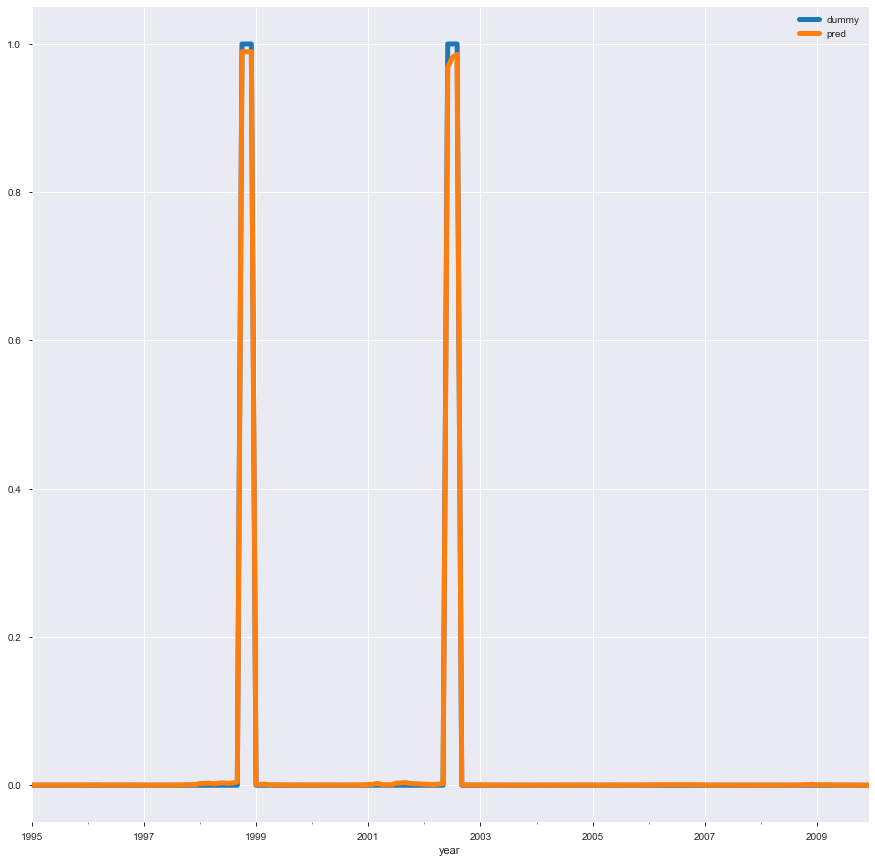

In [197]:
y_prob = model.predict_proba(X)[:,1]
X2 = X
X2["pred"] = y_prob
X2["dummy"] = Y

X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))

In [198]:
full_fill2 = full_fill.loc["1990-01-01":"2019-12-31"]
full_fill2 = full_fill2.drop('exchange_12a', axis = 1)
full_fill2 = full_fill[full_fill["Country_BR"] > 0]
full_fill2 =  full_fill2[full_fill2.columns.drop(list(full_fill2.filter(regex='Country')))]
columns2 = columns.drop(list(full_fill.filter(regex='Country')))

X =  full_fill2[columns2]
#X = X.drop('exchange_12a', axis = 1)
X = X.groupby(["ISO2 Code"]).diff()
#X = X.drop("ISO2 Code",1)
Y = full_fill2['indicator']



X = X.fillna(X.mean())

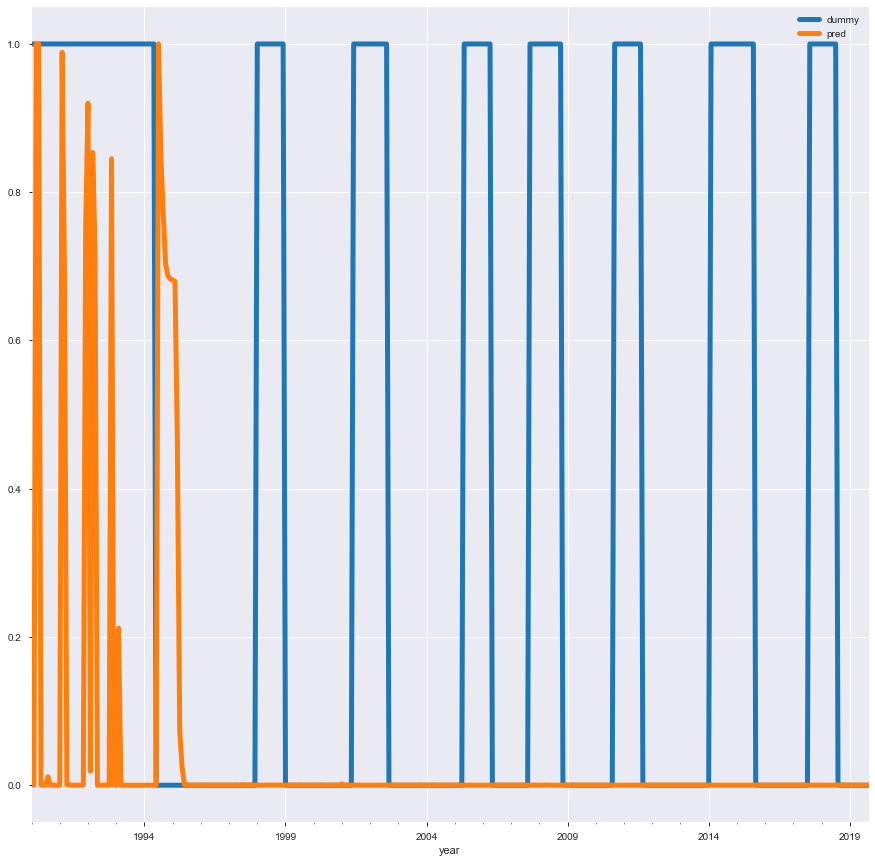

In [1113]:
y_prob = model.predict_proba(X)[:,1]
X2 = X
X2["pred"] = y_prob
cycle, trend = sm.tsa.filters.hpfilter(X2["pred"], lamb=5)
X2["hp"] = trend
X2["dummy"] = Y

X2.plot(y= ["dummy","pred"], linewidth=5, figsize=(15,15))

In [1101]:

full_fill.to_csv("output.csv") 